# Sabermetrics - Starter Code

In this code, you will be using the output of other peoples "models" to come up with a meta prediction (or an _ensemble_ model) about pitcher performance. You will then use the prediction to choose which veteran pitchers to sign.

The right way to think about this exercise is that you will need to make all of the important modeling decisions except for building the model. We will be looking at various ways to measure the performance of our models, and then you will have an opportunity to explore different ways to combine the existing predictions in order to make a better meta-prediction.

## Importing

We import stuff like always. Though there are some changes from notebook to notebook. You should figure out what is necessary for your own projects as you are working through them.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

# Read in the data

The data set here is a data set of pitcher information combined with predictions on the IP (or _innings pitched_) and RA9 (or _runs allowed per 9 innings_). These predictions come from four different groups as stated in the case.

In this assignment, we have two data sets `train_saber.csv` and `test_saber.csv`. `train_saber.csv` are predictions for the 2012 season, which has already happened for Billy Beane, so we also have the realizations for IP and RA9 for the 2012 season. We are trying to predict the 2013 season. `test_saber.csv` has all of the currently available information that Billy Beane would have in making his hiring decisions, but it obviously does not have any data from the 2013 season.

In [3]:
train_df = pd.read_csv("train_saber.csv")

In [4]:
display(train_df.head())

,NAME,IP_fans,RA9_fans,IP_marcel,RA9_marcel,IP_rotochamp,RA9_rotochamp,IP_zips,RA9_zips,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,deathDate,birthDate,IP,RA9
0,Aaron Crow,127,4.187402,56,4.132736,150,3.607945,67.3,4.963657,crowaa01,2012,1,KCA,AL,3,1,73,0,0,0,2,194,54,25,4,22,65,0.231,3.48,2,4,1,0,260,20,27,1,2,NaN,1986,11,10,USA,KS,Topeka,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Crow,Aaron James,195,75,R,R,3/31/2011,9/28/2014,crowa001,crowaa01,NaN,1986-11-10,64.666667,3.757732
1,Aaron Harang,164,4.602863,156,4.701261,180,4.646595,133.7,4.712194,haranaa01,2012,1,LAN,NL,10,10,31,31,0,0,0,539,167,72,14,85,131,0.246,3.61,10,4,4,0,786,0,85,9,10,NaN,1978,5,9,USA,CA,San Diego,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Harang,Aaron Michael,260,79,R,R,5/25/2002,9/27/2014,haraa001,haranaa01,NaN,1978-05-09,179.666667,4.257885
2,Adam Wainwright,196,3.443947,83,3.203417,175,3.771942,173.3,3.411148,wainwad01,2012,1,SLN,NL,14,13,32,32,3,2,0,596,196,87,15,52,184,0.259,3.94,3,5,6,2,831,0,96,9,6,NaN,1981,8,30,USA,GA,Brunswick,NaN,NaN,NaN,NaN,NaN,NaN,Adam,Wainwright,Adam Parrish,235,79,R,R,9/11/2005,9/22/2014,waina001,wainwad01,NaN,1981-08-30,198.666667,4.348993
3,Alex Cobb,103,4.099937,86,4.176469,110,4.209269,122.0,4.351400,cobbal01,2012,1,TBA,AL,11,9,23,23,2,1,0,409,130,61,11,40,106,0.254,4.03,2,8,9,1,569,0,67,3,6,NaN,1987,10,7,USA,MA,Boston,NaN,NaN,NaN,NaN,NaN,NaN,Alex,Cobb,Alexander Miller,200,75,R,R,5/1/2011,9/28/2014,cobba001,cobbal01,NaN,1987-10-07,136.333333,4.422983
4,Alexi Ogando,175,3.826608,130,3.826608,185,4.045271,150.0,4.067137,ogandal01,2012,1,TEX,AL,2,0,58,1,0,0,3,198,49,24,9,17,66,0.203,3.27,1,5,2,0,263,11,26,0,3,NaN,1983,10,5,D.R.,San Pedro de Macoris,San Pedro de Macoris,NaN,NaN,NaN,NaN,NaN,NaN,Alexi,Ogando,Alexi,200,76,R,R,6/15/2010,6/3/2014,ogana001,ogandal01,NaN,1983-10-05,66.000000,3.545455


In [5]:
test_df = pd.read_csv("test_saber.csv")

In [6]:
display(test_df.head())

,NAME,IP_fans,RA9_fans,IP_marcel,RA9_marcel,IP_rotochamp,RA9_rotochamp,IP_zips,RA9_zips,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,deathDate,birthDate,IP,RA9
0,Aaron Crow,66,3.538949,63.7,3.843843,60,3.593394,64.0,4.137848,crowaa01,2013,1,KCA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1986,11,10,USA,KS,Topeka,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Crow,Aaron James,195,75,R,R,2011-03-31,NaN,crowa001,crowaa01,NaN,1986-11-10,NaN,NaN
1,Adam Wainwright,215,3.462725,159.3,3.996290,195,3.462725,173.7,3.724063,wainwad01,2013,1,SLN,NL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1981,8,30,USA,GA,Brunswick,NaN,NaN,NaN,NaN,NaN,NaN,Adam,Wainwright,Adam Parrish,235,79,R,R,2005-09-11,NaN,waina001,wainwad01,NaN,1981-08-30,NaN,NaN
2,Addison Reed,61,3.789397,53.3,4.595189,60,4.246739,66.7,4.257628,reedad01,2013,1,CHA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,12,27,USA,CA,Montclair,NaN,NaN,NaN,NaN,NaN,NaN,Addison,Reed,Addison Devon,220,76,L,R,2011-09-04,NaN,reeda001,reedad01,NaN,1988-12-27,NaN,NaN
3,Al Alburquerque,62,2.929161,36.0,3.538949,55,3.027162,34.7,4.235849,albural01,2013,1,DET,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1986,6,10,D.R.,San Pedro de Macoris,San Pedro de Macoris,NaN,NaN,NaN,NaN,NaN,NaN,Al,Alburquerque,Alberto Jose,195,72,R,R,2011-04-15,NaN,albua001,albural01,NaN,1986-06-10,NaN,NaN
4,Alex Cobb,164,4.159626,133.7,4.181404,140,3.920066,149.3,4.529854,cobbal01,2013,1,TBA,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987,10,7,USA,MA,Boston,NaN,NaN,NaN,NaN,NaN,NaN,Alex,Cobb,Alexander Miller,200,75,R,R,2011-05-01,NaN,cobba001,cobbal01,NaN,1987-10-07,NaN,NaN


In [7]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.concat([pd.DataFrame(df.columns, columns=['Variable Name']), 
                      pd.DataFrame(df.dtypes.values.reshape([-1,1]), columns=['Data Type']),
                      pd.DataFrame(df.isnull().sum().values, columns=['Missing Values']), 
                      pd.DataFrame([df[name].nunique() for name in df.columns], columns=['Unique Values'])], 
                     axis=1).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [46]:
summarize_dataframe(train_df)
describe(train_df["IP"])

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
NAME,object,0,182,182.0,182,Aaron Crow,1,,,,,,,
IP_fans,int64,0,107,182.0,,,,141.467033,58.286836,48.0,69.0,159.5,191.5,242.0
RA9_fans,float64,0,120,182.0,,,,3.947053,0.647344,2.536494,3.44668,3.974206,4.479864,5.444716
IP_marcel,int64,0,100,182.0,,,,119.445055,51.185879,37.0,64.0,126.5,167.0,208.0
RA9_marcel,float64,0,115,182.0,,,,4.058247,0.534799,2.897289,3.673544,4.001538,4.468931,5.499382
IP_rotochamp,int64,0,28,182.0,,,,136.236264,58.484396,30.0,60.0,155.0,190.0,220.0
RA9_rotochamp,float64,0,107,182.0,,,,4.008146,0.740808,1.825839,3.545079,4.045271,4.608329,5.783644
IP_zips,float64,0,148,182.0,,,,128.71978,53.35577,41.7,70.325,140.0,173.225,237.3
RA9_zips,float64,0,129,182.0,,,,4.192568,0.729662,2.405296,3.698143,4.14367,4.695794,6.341236
playerID,object,0,182,182.0,182,crowaa01,1,,,,,,,


NameError: name 'describe' is not defined

(array([12., 23., 49.,  6., 12., 10.,  8., 30., 21., 11.]),
 array([  2.        ,  25.63333333,  49.26666667,  72.9       ,
         96.53333333, 120.16666667, 143.8       , 167.43333333,
        191.06666667, 214.7       , 238.33333333]),
 <BarContainer object of 10 artists>)

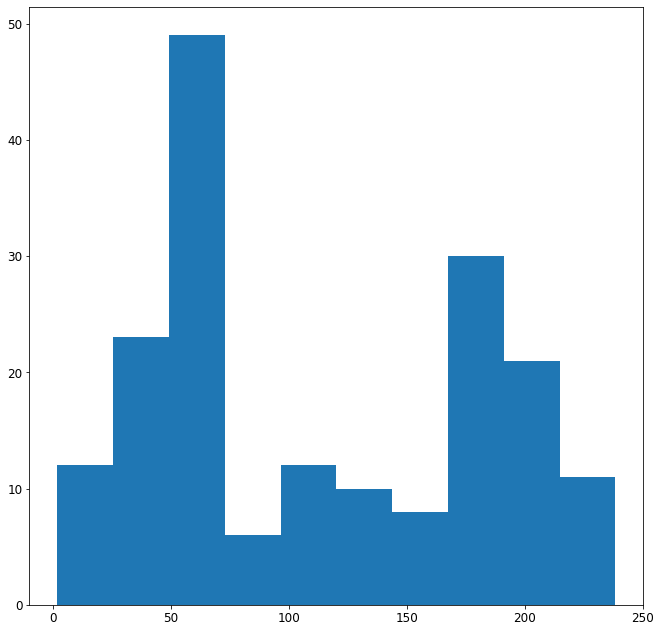

In [52]:
plt.hist(train_df.IP)

## Model building

2012 will be the dataset that you use to "train" your ensemble (i.e. decide how to combine the existing predictions over IP and RA9). Once you have the exact way in which you intend to make your ensemble model, you will then need to apply that same combination procedure to the 2013 data (`test_saber.csv`) in order to get your 2013 predictions.

We'll first focus on evaluating the performance of the given predictions in 2012 (for which we have ground truth). We will be using three metrics. The first two are _root mean squared error_ (RMSE) and _mean absolute error_ (MAE). You can read a primer on these metrics [here](https://www.dataquest.io/blog/understanding-regression-error-metrics/). Note the article also talks about MAPE and MPE. Why are we not using those?

The third metric will be familiar to anyone with a background in linear regression, R^2. A good introduction to R^2 can be found [here](https://towardsdatascience.com/statistics-for-machine-learning-r-squared-explained-425ddfebf667). What is useful about R^2?

We will see other metrics as we go through the course, but these are some of the most common.

We will define a function to make it more convenient to run all of the metrics at once.

In [10]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)]})
    display(acc_df.style.hide_index())

Let's look at the accuracy of the models that we have for IP.

In [11]:
print("Accuracy of IP_fans is:")
accuracy(train_df["IP"], train_df["IP_fans"])

Accuracy of IP_fans is:


RMSE,MAE,R^2
58.481914,40.256410,0.263708


In [12]:
print("Accuracy of IP_marcel is:")
accuracy(train_df["IP"], train_df["IP_marcel"])

Accuracy of IP_marcel is:


RMSE,MAE,R^2
53.509154,39.582418,0.383600


In [18]:
print("Accuracy of IP_rotochamp is:")
accuracy(train_df["IP"], train_df["IP_rotochamp"])

Accuracy of IP_rotochamp is:


RMSE,MAE,R^2
57.659848,39.479853,0.284263


In [19]:
print("Accuracy of IP_zips is:")
accuracy(train_df["IP"], train_df["IP_zips"])

Accuracy of IP_zips is:


RMSE,MAE,R^2
54.523902,39.421612,0.359999


First, notice that not all metrics agree on which model is the best. This means that you have to choose which metric you are going to use to do _model selection_. This is an important choice, and you should give it some thought as you are deciding on how to build your ensemble to evaluate the 2013 pitchers. Each of the metrics penalizes different errors differently. As Billy Beane, what errors do you care about the most?

We will also find it useful to look at the errors the models make themselves. In order to do this, I'm going to make a DataFrame of the errors. Here I am defining an error as `(predicted - actual)`. Sometimes, people will use the opposite definition.

In [15]:
errors_df = pd.DataFrame({"Fans_IP_error": train_df["IP_fans"] - train_df["IP"],
                          "Marcel_IP_error": train_df["IP_marcel"] - train_df["IP"],
                          "Rotochamp_IP_error": train_df["IP_rotochamp"] - train_df["IP"],
                          "Zips_IP_error": train_df["IP_zips"] - train_df["IP"]})

In [20]:
errors_df.head()

,Fans_IP_error,Marcel_IP_error,Rotochamp_IP_error,Zips_IP_error
0,62.333333,-8.666667,85.333333,2.633333
1,-15.666667,-23.666667,0.333333,-45.966667
2,-2.666667,-115.666667,-23.666667,-25.366667
3,-33.333333,-50.333333,-26.333333,-14.333333
4,109.000000,64.000000,119.000000,84.000000


Then, we can get an idea for whether or not or models are _biased_, i.e. whether they systematically over or under predict. We do this by looking at the _mean error_, which is just the average of all the errors.

In [21]:
errors_df.mean(axis=0)

Fans_IP_error         28.344322
Marcel_IP_error        6.322344
Rotochamp_IP_error    23.113553
Zips_IP_error         15.597070
dtype: float64

Are the models biased? In which direction? What does this say about how you should think about combining them? Or put another way, if you use some kind of averaging of these models in order to get your prediction, will your resulting model be biased?

When ensembling, it is often better to use very different models in the ensemble because the diversity of models increases the likelihood of bracketing the true value. Correlation between the model predictions is a good way to measure the similarity of the models. Note that a higher correlation, means the models are more similar. We can easily computer the _correlation matrix_ from the `errors_df`.

In [22]:
errors_df.corr()

,Fans_IP_error,Marcel_IP_error,Rotochamp_IP_error,Zips_IP_error
Fans_IP_error,1.000000,0.890679,0.948952,0.904915
Marcel_IP_error,0.890679,1.000000,0.881627,0.894794
Rotochamp_IP_error,0.948952,0.881627,1.000000,0.891549
Zips_IP_error,0.904915,0.894794,0.891549,1.000000


## Building Ensembles

Now that we have an understanding of the performance of the underlying models, we can start building an ensemble. Below we are going to build three such simple ensembles.

The first will just be combining the best (Zips) and worst (Fans) models according to MAE. The second will be averaging all of the models. The third will be averaging all models except for Fans (the worst model according to MAE).

In [23]:
IP_pred_2012_best_and_worst = train_df[["IP_fans", "IP_zips"]].mean(axis=1)
IP_pred_2012_all = train_df[["IP_fans", "IP_marcel", "IP_rotochamp", "IP_zips"]].mean(axis=1)
IP_pred_2012_last_three = train_df[["IP_marcel", "IP_rotochamp", "IP_zips"]].mean(axis=1)

In [24]:
print("Performance of best and worst ensemble:")
accuracy(train_df["IP"], IP_pred_2012_best_and_worst)
print("Performance of all ensemble:")
accuracy(train_df["IP"], IP_pred_2012_all)
print("Performance of top three ensemble:")
accuracy(train_df["IP"], IP_pred_2012_last_three)

Performance of best and worst ensemble:


RMSE,MAE,R^2
55.031937,38.695971,0.348017


Performance of all ensemble:


RMSE,MAE,R^2
53.612898,37.929487,0.381207


Performance of top three ensemble:


RMSE,MAE,R^2
52.924817,38.137729,0.396989


How do the models do?

Often times, it is helpful to visualize the performance of our model (or ensemble model in this case). The plot below plots the ensemble prediction (using all models) on the horizontal axis and the realization on the vertical axis. If our model was perfect, where should all of the points be? What can you discern from where the points are?

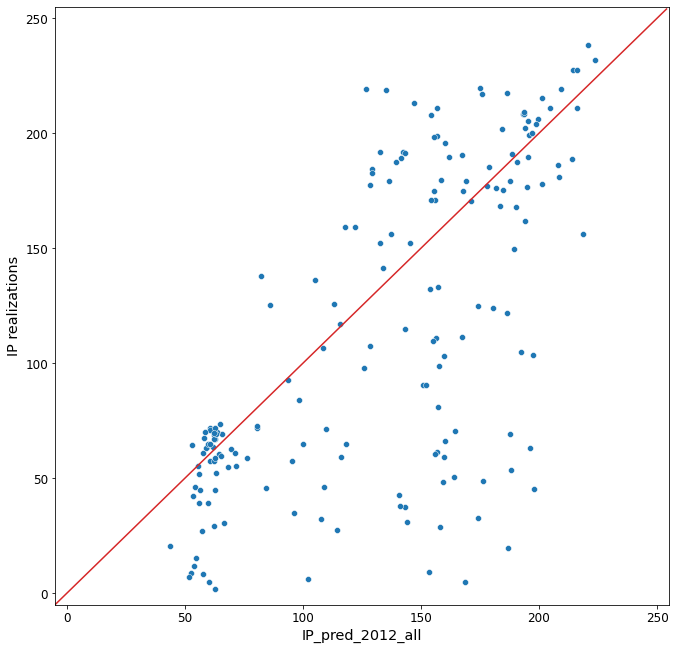

In [25]:
sns.lineplot(x = list(range(-5,255)), y = list(range(-5,255)), color='tab:red')
sns.scatterplot(x = IP_pred_2012_all, y = train_df["IP"])
plt.xlabel("IP_pred_2012_all")
plt.ylabel("IP realizations")
plt.xlim([-5,255])
plt.ylim([-5,255])
plt.show()


# Study bracketing of best-and-worst ensemble

A large reason to ensemble models is because if you can bracket (i.e. the true prediction lies between your model predictions), the average of the model predictions is going to closer to the true prediction than the average model will be. If you do not bracket, then your performance (on average) is no worse than the average model, so you just gain when you are able to successfully bracket.

Therefore, let's look at how often we successfully bracket using Fans and Zips (the worst and best from above). The below line of code identifies every pitcher for which those two models bracket. I encourage you to study the line of code until you convince yourself that this is true.

In [26]:
bracketing = (train_df["IP"] - train_df["IP_fans"])*(train_df["IP"] - train_df["IP_zips"]) <= 0

What is this `bracketing` variable?

In [27]:
bracketing

0      False
1      False
2      False
3      False
4      False
       ...  
177    False
178    False
179    False
180    False
181    False
Length: 182, dtype: bool

It is just a boolean series that has a `True` everytime we bracket. What is the percentage of time we bracket?

In [28]:
bracketing.mean()

0.19230769230769232

When we take the `mean` of a boolean series, it treats all `True` as `1` and all `False` as 0, so we bracket about 19% of the time. How many pitchers is that?

In [29]:
len(train_df[bracketing])

35

`train_df[bracketing]` is just a dataframe with only pitchers that we successfully bracket. If we look at the length of that dataframe (using `len`), we see there are 35 pitchers in it.

We can also directly look at this bracketing in the below plot.

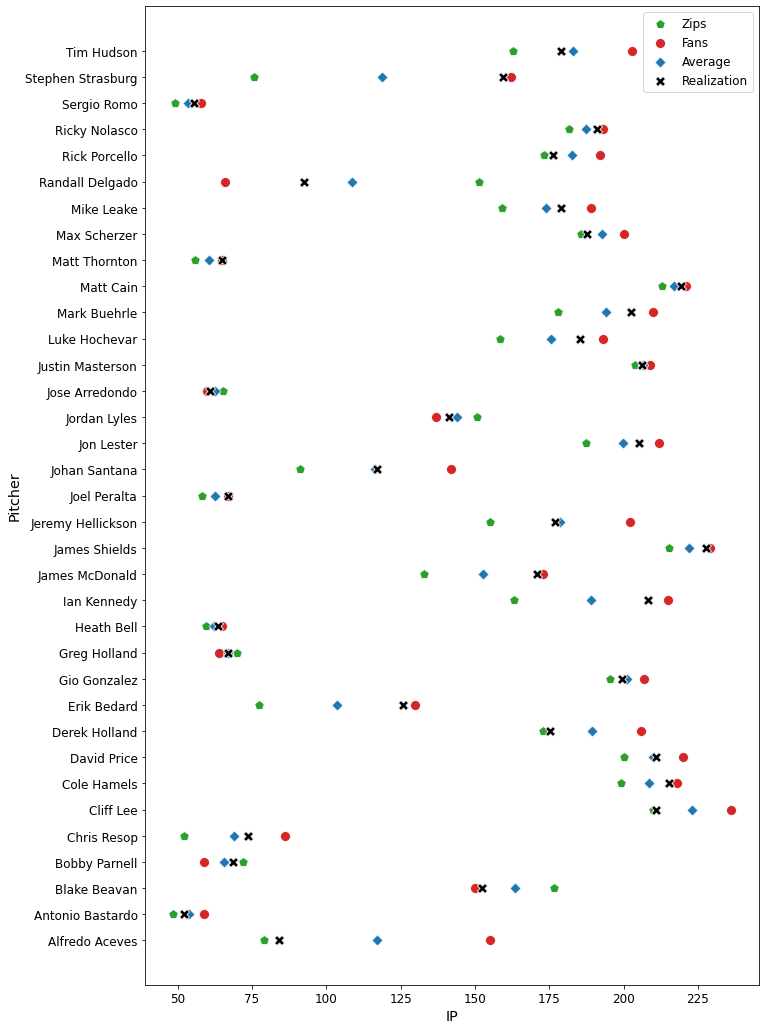

In [30]:
plt.figure(figsize=(11,18))
y_values = range(0, len(train_df[bracketing]))
sns.scatterplot(x = train_df[bracketing]["IP_zips"], y = y_values, marker="p", color="tab:green", label="Zips", s = 100)
sns.scatterplot(x = train_df[bracketing]["IP_fans"], y = y_values, marker="o", color="tab:red", label="Fans", s = 100)
sns.scatterplot(x = IP_pred_2012_best_and_worst[bracketing], y = y_values, marker="D", color="tab:blue", label="Average", s = 60)
sns.scatterplot(x = train_df[bracketing]["IP"], y = y_values, marker="X", color="black", label="Realization", s = 100)
plt.yticks(y_values, train_df[bracketing]['NAME'].values)
plt.xlabel("IP")
plt.ylabel("Pitcher")
plt.show()

## Build Your Own Ensemble

We've looked at some obvious ensembles above. In this section, build your own ensemble.

A couple of tips. First, we have only looked at simple averaging of models above. That is not necessary. You could, for example, take a weighted average. Moreover, you do not have to combine models by averaging. The model predictions are just data, and you can treat them like any other data when it comes to building a predictive model. You will need to build an ensemble for both IP and RA9 to use in your decision process for choosing a pitcher. The better you can predict these values, the better you will do in choosing a pitcher.

Note that after you have chosen how to build your ensemble using the `train_df`, you will then need to use the same construction to actually get predictions from the `test_df` (i.e., if you average the Fans and Zips prediction for `train_df` do the same thing on `test_df`). Don't forget to do this part, and remember the datasets are the same as far as the Fans, Zips, Marcel, and Rotochamp models go, it's just that `test_df` doesn't have the 2013 season realizations.

Save your predictions for 2013 in a variable called `IP_pred_2013` and `RA9_pred_2013`.

You should be able to follow the above pattern quite closely. For example, if you wanted to average all of the models, you could use the exact same code as above but change `train` for `test`. If your experimenting on the training set looked like this:

In [31]:
IP_pred_2012_all = train_df[["IP_fans", "IP_marcel", "IP_rotochamp", "IP_zips"]].mean(axis=1)

Then to do this on the test data, you would do:

In [32]:
IP_pred_2013_all = test_df[["IP_fans", "IP_marcel", "IP_rotochamp", "IP_zips"]].mean(axis=1)

Now, you have a prediction for 2013! Probably it won't win the competition, but it is a prediction. If you would like to use the above rename `IP_pred_2013_all` to `IP_pred_2013`.

Similarly when you are doing predictions for RA9, replace `IP` with `RA9` in the column names like so:

In [33]:
RA9_pred_2012_all = train_df[["RA9_fans", "RA9_marcel", "RA9_rotochamp", "RA9_zips"]].mean(axis=1)

You can evaluate your predictions on `RA9` when using the training set like so:

In [40]:
accuracy(train_df["RA9"], RA9_pred_2012_all)
train_df.head()

RMSE,MAE,R^2
1.472807,1.001277,0.090442


,NAME,IP_fans,RA9_fans,IP_marcel,RA9_marcel,IP_rotochamp,RA9_rotochamp,IP_zips,RA9_zips,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,deathDate,birthDate,IP,RA9
0,Aaron Crow,127,4.187402,56,4.132736,150,3.607945,67.3,4.963657,crowaa01,2012,1,KCA,AL,3,1,73,0,0,0,2,194,54,25,4,22,65,0.231,3.48,2,4,1,0,260,20,27,1,2,NaN,1986,11,10,USA,KS,Topeka,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Crow,Aaron James,195,75,R,R,3/31/2011,9/28/2014,crowa001,crowaa01,NaN,1986-11-10,64.666667,3.757732
1,Aaron Harang,164,4.602863,156,4.701261,180,4.646595,133.7,4.712194,haranaa01,2012,1,LAN,NL,10,10,31,31,0,0,0,539,167,72,14,85,131,0.246,3.61,10,4,4,0,786,0,85,9,10,NaN,1978,5,9,USA,CA,San Diego,NaN,NaN,NaN,NaN,NaN,NaN,Aaron,Harang,Aaron Michael,260,79,R,R,5/25/2002,9/27/2014,haraa001,haranaa01,NaN,1978-05-09,179.666667,4.257885
2,Adam Wainwright,196,3.443947,83,3.203417,175,3.771942,173.3,3.411148,wainwad01,2012,1,SLN,NL,14,13,32,32,3,2,0,596,196,87,15,52,184,0.259,3.94,3,5,6,2,831,0,96,9,6,NaN,1981,8,30,USA,GA,Brunswick,NaN,NaN,NaN,NaN,NaN,NaN,Adam,Wainwright,Adam Parrish,235,79,R,R,9/11/2005,9/22/2014,waina001,wainwad01,NaN,1981-08-30,198.666667,4.348993
3,Alex Cobb,103,4.099937,86,4.176469,110,4.209269,122.0,4.351400,cobbal01,2012,1,TBA,AL,11,9,23,23,2,1,0,409,130,61,11,40,106,0.254,4.03,2,8,9,1,569,0,67,3,6,NaN,1987,10,7,USA,MA,Boston,NaN,NaN,NaN,NaN,NaN,NaN,Alex,Cobb,Alexander Miller,200,75,R,R,5/1/2011,9/28/2014,cobba001,cobbal01,NaN,1987-10-07,136.333333,4.422983
4,Alexi Ogando,175,3.826608,130,3.826608,185,4.045271,150.0,4.067137,ogandal01,2012,1,TEX,AL,2,0,58,1,0,0,3,198,49,24,9,17,66,0.203,3.27,1,5,2,0,263,11,26,0,3,NaN,1983,10,5,D.R.,San Pedro de Macoris,San Pedro de Macoris,NaN,NaN,NaN,NaN,NaN,NaN,Alexi,Ogando,Alexi,200,76,R,R,6/15/2010,6/3/2014,ogana001,ogandal01,NaN,1983-10-05,66.000000,3.545455


You can not evaluate your predictions on the test set. If this is not obvious, think about why and come to class ready to discuss.

Now use the space below to try out different ensembling methods for both `IP` and `RA9` and ultimately construct predictions on the testing data from 2013 and save them to variables called `IP_pred_2013` and `RA9_pred_2013`.

In [53]:
## Choose testing criterion

# IP: MAE
# RA9: RMSE

errors_df.mean(axis=0)


Fans_IP_error         28.344322
Marcel_IP_error        6.322344
Rotochamp_IP_error    23.113553
Zips_IP_error         15.597070
dtype: float64

# Pick your Pitchers

After you build your predictions, use them, along with the other data in the case, to choose the pitchers you will sign. You will need to get the predicted IP and RA9 of all of the free agent pitchers in exhibit 4. Below is an easy way to find the indices of all of the pitchers.

In [ ]:
free_agents = ["Andy Pettitte",
               "Bartolo Colon",
               "Brandon McCarthy",
               "Francisco Liriano",
               "Hiroki Kuroda",
               "Joe Blanton",
               "Joe Saunders",
               "Kevin Correia",
               "Paul Maholm",
               "Ryan Dempster",
               "Shaun Marcum",
               "Anibal Sanchez",
               "Brett Myers",
               "Hisashi Iwakuma",
               "Jeremy Guthrie",
               "Zack Greinke"]

In [ ]:
test_df.loc[test_df["NAME"].isin(free_agents)]

You can just get the indices (which you can then use to access just the rows from your predictions) with:

In [ ]:
free_agent_indices = test_df["NAME"].isin(free_agents)

In [ ]:
free_agent_indices

The following code will help you more easily read out your predictions for the individual pitchers in order to use the predictions in your decision. Note that until you have the variables `IP_pred_2013` and `RA9_pred_2013`, you will get an error if you try to run the below cell.

In [ ]:
pd.DataFrame({'Name': test_df[free_agent_indices]["NAME"], 
              'Prediction IP 2013': IP_pred_2013[free_agent_indices], 
              'Prediction RA9 2013': RA9_pred_2013[free_agent_indices]}).set_index('Name')

# Write Out Predictions

After you have your predictions, it will be helpful to write them out.

The following code will create a dataframe that has two columns, the first column will be the pitcher name, and the second column will be the prediction for that pitcher's `IP` for 2013.

In [ ]:
predictions_df = pd.concat([test_df['NAME'], IP_pred_2013.rename('IP')], axis=1)

In [ ]:
predictions_df.to_csv("IP_predictions_2013.csv", index=False)

Once your predictions are written out, download the file `IP_predictions_2013.csv` by right clicking on it in the sidebar and selecting "Download". This can then be used to go about selecting the pitchers that you would sign.

# Read in Realizations

In class, you will receive a realizations data set. Assuming that you have `IP_pred_2013` and `RA9_pred_2013` calculated from work above, running the below code will show your accuracy.

In [ ]:
test_real_df = pd.read_csv("../Shared Data (Read Only)/Sabermetrics_SPF/test_saber_realization.csv")

In [ ]:
print("Your IP prediction performance was:")
accuracy(test_real_df["IP"], IP_pred_2013)

In [ ]:
print("Your RA9 prediction performance was:")
accuracy(test_real_df["RA9"], RA9_pred_2013)